# Churn Project Preliminary Modeling and Grid Search

In [3]:
import os
import sys
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sys.path.append('/Users/maboals/Documents/Work/Programming/PyStuff/MyTools/src')
from MLModelingTools import model_test, model_testN

import umap


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


## Get the clean training data

Read the training data file.  This file was created by running the notebooks:
* Telecom to SQL
* Telecom clean and eda

In [6]:
# Read the csv file save by the clean/eda notebook
train_df = pd.read_csv('../data/churn_train_clean.csv')


# Sometimes the index column is read as an unnamed column, if so drop it
if 'Unnamed: 0' in train_df.columns :
    train_df = train_df.drop('Unnamed: 0', axis=1)
    
train_df.columns

Index(['customerID', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'Month-to-month', 'One year', 'DSL', 'Fiber optic', 'Female'],
      dtype='object')

In [7]:
# Define which columns we're going to use in our modeling.
train_columns1 = ['SeniorCitizen', 'Partner', 'Dependents', \
       'tenure', 'PhoneService', 'MultipleLines',  \
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
       'StreamingTV', 'StreamingMovies', 'MonthlyCharges', 'TotalCharges', \
       'Month-to-month', 'One year', 'Fiber optic', 'Female']

train_columns2 = ['SeniorCitizen', 'Partner', 'Dependents', \
       'tenure', 'PhoneService', 'MultipleLines',  \
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
       'StreamingTV', 'StreamingMovies', \
       'Month-to-month', 'One year', 'Fiber optic', 'MonthlyCharges', 'Female']

train_columns = train_columns2

X = train_df[train_columns]
y= train_df['Churn']

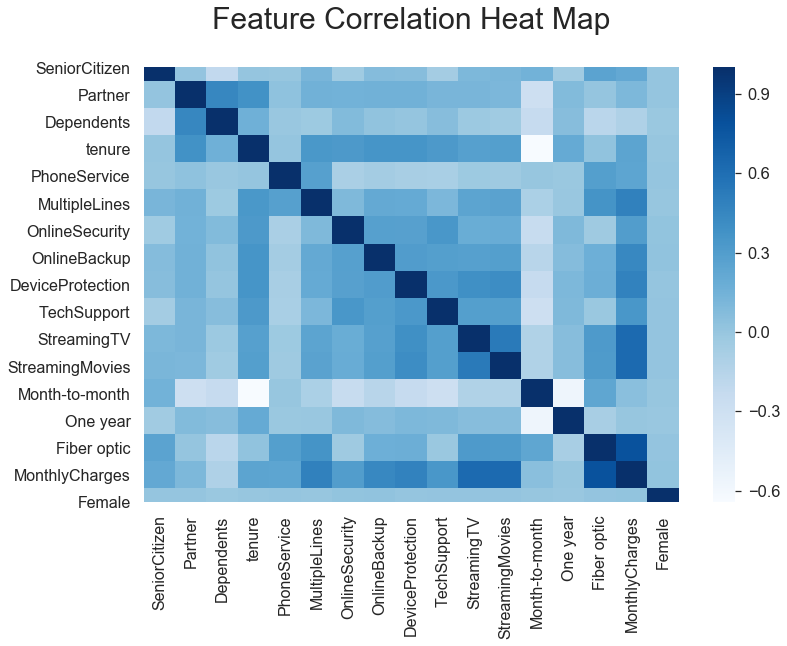

In [19]:
corr = X.corr()
fig = plt.figure(figsize=[12,8])

fig.patch.set_alpha(0.)
sns.set(font_scale=1.5)
g = sns.heatmap(data=corr, cmap = "Blues")
g.set_xticklabels(corr.columns, fontsize = 16)
g.set_yticklabels(corr.columns, fontsize = 16)

#sns.heatmap(corr, cmap='Blues', )
plt.title('Feature Correlation Heat Map\n', size=30)
plt.savefig('feature_heatmap.png', Transparent=True)

In [20]:
def calc_roc_data(model, X_dat, y_dat, n_step) :
    threshold_list = np.linspace(0, 1, n_step, endpoint=True)
    roc_data = [[0,0,0]]

    for i, threshold in enumerate(threshold_list) :
        y_predict = (model.predict_proba(X_dat)[:, 1] >= threshold)
        confusion_m = confusion_matrix(y_dat, y_predict)
        fpr = confusion_m[1][0] / (confusion_m[1][0]+confusion_m[1][1])
        tpr = confusion_m[0][0] / (confusion_m[0][0]+confusion_m[0][1])
        roc_data.append([threshold, fpr, tpr])
        
    roc_data.append([1,1,1])    

    return roc_data

######

def cal_f_beta(tpr, fpr, beta) :
    weighted_ave = (beta**2 * (tpr+1) * fpr) / (beta**2 + 1)
    return (tpr*fpr) / weighted_ave

### Train, test split

Make a training data subset and a validation data subset

Then make a balanced training dataset using smote

In [21]:
# Split the original dataset into train and validation groups
#  set stratify to true so both classes are represented it the splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Make a balance set for model training
sm = SMOTE(random_state=42)
X_train_smt, y_train_smt = sm.fit_resample(X_train, y_train)

### Baseline with Logistic Regression

Make a process pipeline to use the grid search cross validation tool

In [26]:
sm = SMOTE(random_state=42)
log_model = LogisticRegression()
steps = [('smt', sm), ('LOG', log_model)]

pipeline = Pipeline(steps) # define the pipeline object.

In [27]:
log_param_grid = {
    'smt__random_state': [45],
    'LOG__solver': ['liblinear', 'sag'],
    'LOG__C' : [0.1, 0.5, 0.75, 1, 1.5, 3, 10, 20],
    'LOG__penalty' : ['l1', 'l2', 'elasticnet']
}

In [28]:
log_grid = GridSearchCV(pipeline, param_grid=log_param_grid, cv=5, n_jobs=-1)

In [29]:
log_grid.fit(X_train, y_train)
print("score = %3.2f" %(log_grid.score(X_test,y_test)))
print(log_grid.best_params_)

score = 0.76
{'LOG__C': 0.1, 'LOG__penalty': 'l1', 'LOG__solver': 'liblinear', 'smt__random_state': 45}


### Create model validation pipeline and do grid search for KNN Model

In [30]:
from imblearn.pipeline import Pipeline
sm = SMOTE(random_state=42)
knn = KNeighborsClassifier()
steps = [('smt', sm), ('KNN', knn)]

pipeline = Pipeline(steps) # define the pipeline object.

Set the parameters for the pipeline steps

In [31]:
knn_param_grid = {
    'smt__random_state': [45],
    'KNN__n_neighbors': [2, 4, 6, 8, 10],
}


Use grid search to find the optimum parameters for the Knn model

In [32]:
knn_grid = GridSearchCV(pipeline, param_grid=knn_param_grid, cv=5, n_jobs=-1)

In [33]:
knn_grid.fit(X_train, y_train)
print("score = %3.2f" %(knn_grid.score(X_test,y_test)))
print(knn_grid.best_params_)

score = 0.74
{'KNN__n_neighbors': 4, 'smt__random_state': 45}


## Random Forest Classifier

Build the pipeline and search parameter grid for random forest

In [34]:
sm = SMOTE(random_state=42)
rf = RandomForestClassifier()
steps = [('smt', sm), ('RFC', rf)]

rf_pipeline = Pipeline(steps) # define the pipeline object.

In [35]:
rf_param_grid = {
    'smt__random_state': [10],
    'RFC__n_estimators': [50, 100, 150, 200, 1000],
    'RFC__max_depth' : [2,3,4],
    'RFC__max_features' : [5, 10, 15],
    'RFC__criterion' : ['gini', 'entropy'],
    'RFC__random_state' :[42]
}

In [36]:
rf_grid = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, cv=5, n_jobs=-1)

In [37]:
rf_grid.fit(X_train, y_train)
print("score = %3.2f" %(rf_grid.score(X_test,y_test)))
print(rf_grid.best_params_)

score = 0.76
{'RFC__criterion': 'gini', 'RFC__max_depth': 4, 'RFC__max_features': 10, 'RFC__n_estimators': 100, 'RFC__random_state': 42, 'smt__random_state': 10}


With Random Forest we can get a rating of relative feature importance.

In [40]:
rf_best = RandomForestClassifier(max_depth=4, max_features=10, \
                n_estimators=100, criterion='gini', random_state=42)
rf_best.fit(X_train_smt, y_train_smt)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [42]:
rf_importances = rf_best.feature_importances_
rf_importances

array([8.15552685e-05, 5.10244709e-03, 1.20490642e-02, 1.78783790e-01,
       4.18551778e-03, 1.66248514e-03, 7.11481589e-02, 3.26988507e-03,
       3.55013027e-03, 4.15695679e-02, 3.15061011e-04, 2.26633069e-03,
       4.57851942e-01, 3.85333051e-03, 9.88174267e-02, 1.14979472e-01,
       5.13834995e-04])

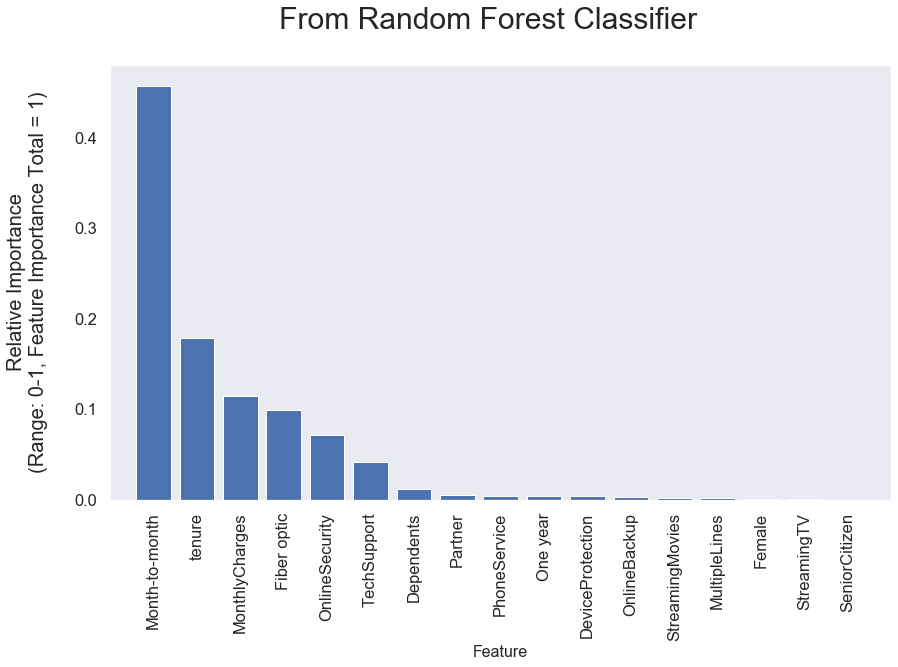

<Figure size 576x396 with 0 Axes>

In [43]:
# Plot the feature importances of the forest
indices = np.argsort(rf_importances)[::-1]
index_labels = [X_train.columns[x] for x in indices]

fig = plt.figure(figsize=[14,8])

fig.patch.set_alpha(0.)

plt.grid(0)
plt.suptitle("Feature importances", size=30)
plt.suptitle("From Random Forest Classifier\n", size=30)
plt.xlabel('Feature', size=16)
plt.ylabel('Relative Importance\n(Range: 0-1, Feature Importance Total = 1)\n', size=20)
plt.bar(range(X_train.shape[1]), rf_importances[indices],
       color="b", align="center")
plt.xticks(range(X_train.shape[1]), labels=index_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()
plt.savefig('FeatureImportances.png', Transparent=True)

### Support Vector Classifier

SVM shouldn't help but let's run an SVM anyway

In [44]:
svc = SVC(probability=True)

steps = [('smt', sm), ('SVC', svc)]

svc_pipeline = Pipeline(steps) # define the pipeline object.

In [45]:
svc_param_grid = {
    'smt__random_state': [10],
    'SVC__kernel': ['linear', 'rbf'],
    'SVC__C' : [0.5, 1, 1.5],
    'SVC__random_state' :[42]
}

In [48]:
svc_grid = GridSearchCV(svc_pipeline, param_grid=svc_param_grid, cv=5, n_jobs=-1)

In [49]:
svc_grid.fit(X_train, y_train)
print("score = %3.2f" %(svc_grid.score(X_test,y_test)))
print(svc_grid.best_params_)

score = 0.76
{'SVC__C': 1, 'SVC__kernel': 'linear', 'SVC__random_state': 42, 'smt__random_state': 10}


### Naive Bayes

Configure the grid search for Naive Bayes

In [51]:
nb = GaussianNB()
# define the pipeline object.

steps = [('smt', sm), ('NB', nb)]

pipeline = Pipeline(steps) # define the pipeline object.

In [52]:
nb_param_grid = {
    'smt__random_state': [45],
    'NB__var_smoothing': [0.0, 0.5, 1.0, 1.5, 10]

}

In [53]:
nb_grid = GridSearchCV(pipeline, param_grid=nb_param_grid, cv=5, n_jobs=-1)

In [54]:
nb_grid.fit(X_train, y_train)
print("score = %3.2f" %(nb_grid.score(X_test,y_test)))
print(nb_grid.best_params_)

score = 0.72
{'NB__var_smoothing': 0.0, 'smt__random_state': 45}
